#### <a>Objective: To predict the Energy Consumption of Appliances.

#### <a>Business Context

The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods.
    
The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters).
    
#### <a>Data Availability
    
Data used include measurements of temperature and humidity sensors from a wireless network, weather from a nearby airport station and recorded energy use of lighting fixtures. data filtering to remove non-predictive parameters and feature ranking plays an important role with this data. Different statistical models could be developed over this dataset.
    
#### <a>Highlights:
    
The appliances energy consumption prediction in a low energy house is the dataset content
Weather data from a nearby station was found to improve the prediction.

Pressure, air temperature and wind speed are important parameters in the prediction.

Data from a WSN that measures temperature and humidity increase the pred. accuracy.

From the WSN, the kitchen, laundry and living room data ranked high in importance.
    
<b><a>Data Source:</a></b> https://www.kaggle.com/loveall/appliances-energy-prediction

#### Importing Modules

In [1]:
import numpy as np
import pandas as pd

import pandas_profiling

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_selection import f_regression, RFE
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn import metrics

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#### Creating UDFs

In [2]:
# Create Statistical Summary for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), len(x.value_counts()), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05), x.quantile(0.50),
                      x.quantile(0.95), x.quantile(0.99),x.max()], 
                      index = ['Count', 'Unique', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN',
                               'P1', 'P5', 'P50', 'P95', 'P99' ,'MAX'])

In [3]:
#Outlier treatment function
def outlier_capping(x):
    x = x.clip(lower = x.quantile(0.01),upper = x.quantile(0.99))
    return x

In [4]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode().iloc[0])
    return x

In [5]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

#### Loading Dataset

In [6]:
data_energy = pd.read_csv('Dataset/KAG_energydata_complete.csv')

#### Understanding data

In [7]:
#Data View
data_energy.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [8]:
#Basic Data Information
data_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [9]:
#For prediction model date variable has no significance, therefore dropping date variable
data_energy.drop('date', axis = 1, inplace = True)

#### Statistical Summary

In [10]:
data_energy.apply(continuous_var_summary).T

,Count,Unique,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P50,P95,P99,MAX
Appliances,19735.0,92.0,0.0,1.928010e+06,97.694958,60.000000,102.524891,10511.353180,10.000000,20.000000,30.000000,60.000000,330.000000,576.600000,1080.000000
lights,19735.0,8.0,0.0,7.503000e+04,3.801875,0.000000,7.935988,62.979899,0.000000,0.000000,0.000000,0.000000,20.000000,30.000000,70.000000
T1,19735.0,722.0,0.0,4.279845e+05,21.686571,21.600000,1.606066,2.579447,16.790000,17.790000,19.100000,21.600000,24.726455,25.500000,26.260000
RH_1,19735.0,2547.0,0.0,7.945260e+05,40.259739,39.656667,3.979299,15.834819,27.023333,32.628933,34.700000,39.656667,47.326667,50.492200,63.360000
T2,19735.0,1650.0,0.0,4.014340e+05,20.341219,20.000000,2.192974,4.809133,16.100000,16.555667,17.323333,20.000000,24.557667,26.952857,29.856667
RH_2,19735.0,3376.0,0.0,7.976970e+05,40.420420,40.500000,4.069813,16.563374,20.463333,30.210200,33.432333,40.500000,46.664333,49.790000,56.026667
T3,19735.0,1426.0,0.0,4.394513e+05,22.267611,22.100000,2.006111,4.024479,17.200000,18.100000,19.500000,22.100000,26.200000,27.133333,29.236000
RH_3,19735.0,2618.0,0.0,7.744507e+05,39.242500,38.530000,3.254576,10.592268,28.766667,33.663333,34.760000,38.530000,45.090000,46.500000,50.163333
T4,19735.0,1390.0,0.0,4.115800e+05,20.855335,20.666667,2.042884,4.173377,15.100000,15.860000,17.790000,20.666667,24.500000,25.600000,26.200000
RH_4,19735.0,2987.0,0.0,7.701959e+05,39.026904,38.400000,4.341321,18.847065,27.660000,31.790000,33.000000,38.400000,46.790000,49.200000,51.090000


#### Data preparation

In [11]:
#Checking for missing values
data_energy.isna().sum()

Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

In [12]:
#Handling Outliers
data_energy = data_energy.apply(outlier_capping)

#### EDA

2.9678491702332375


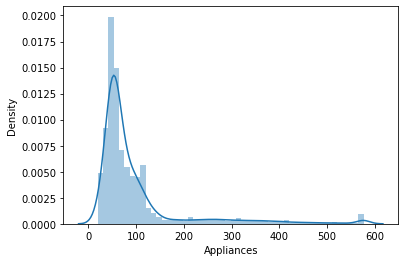

In [13]:
#Checking the distribution of target variable
sns.distplot(data_energy.Appliances,
              kde = True)
print(data_energy.Appliances.skew())

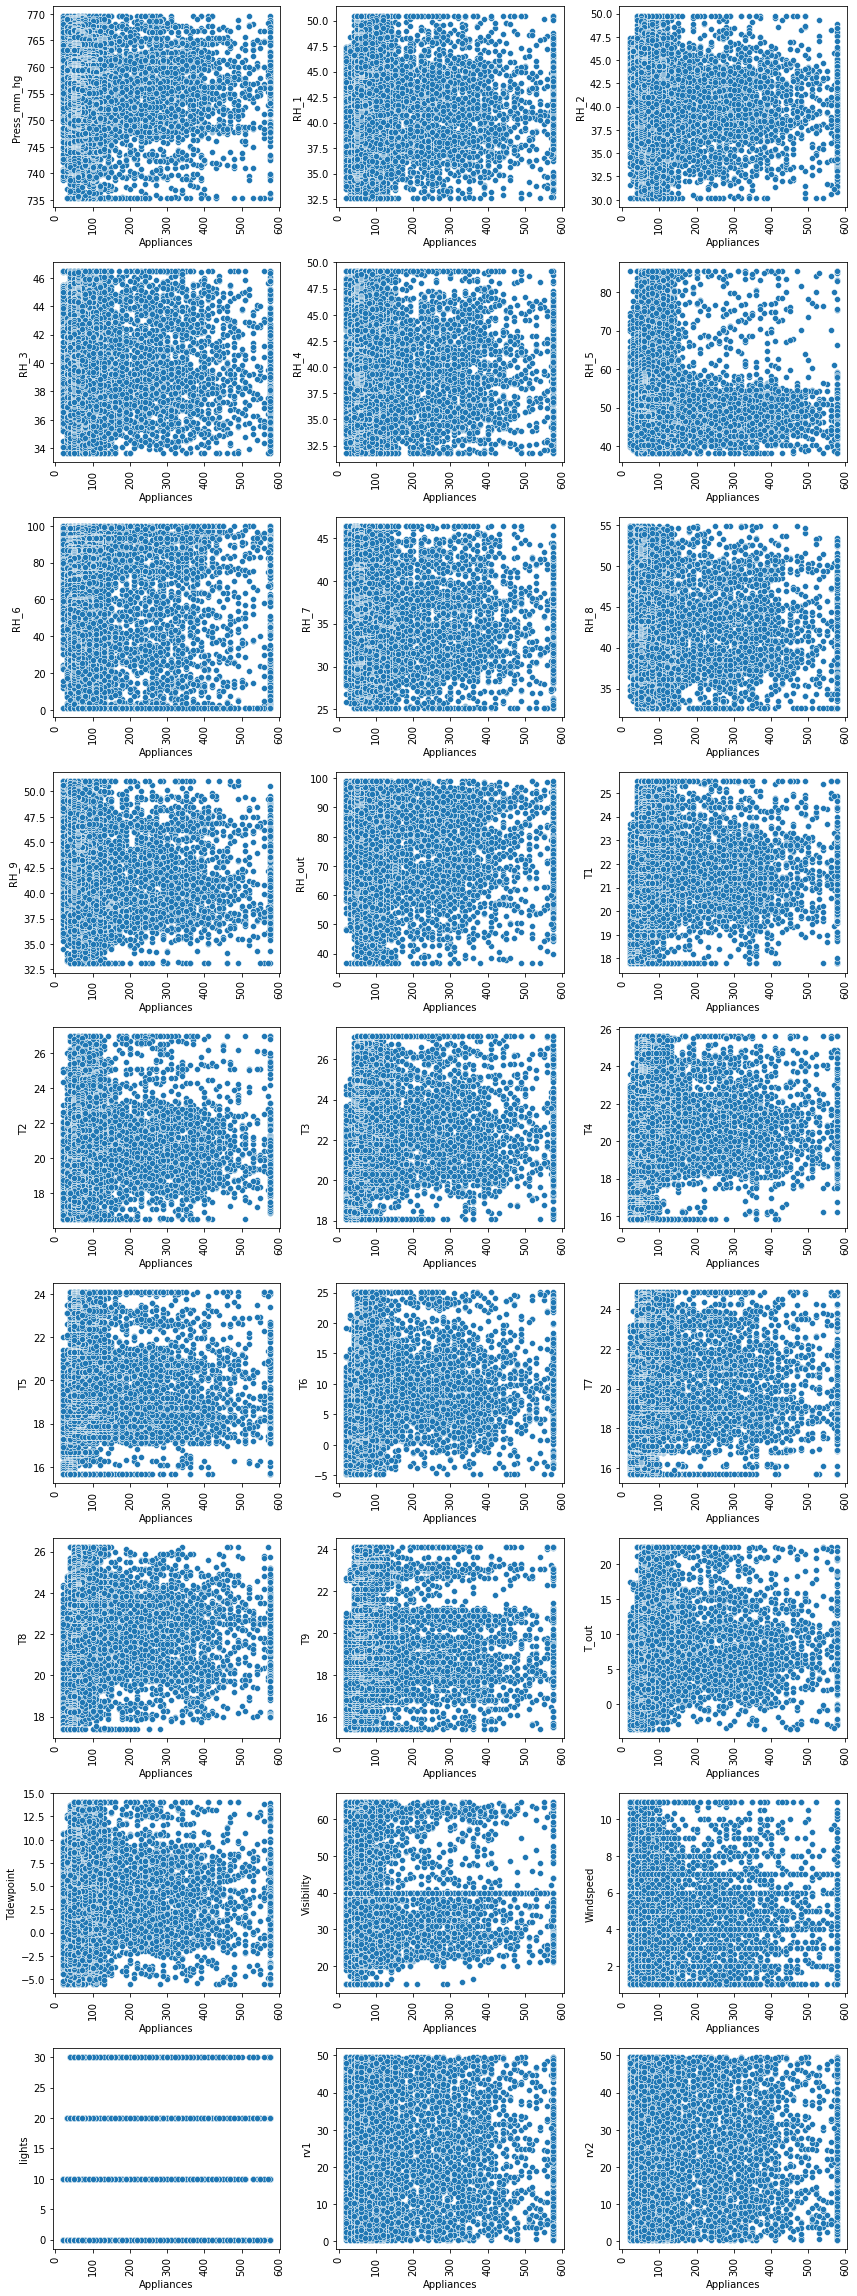

In [14]:
#Appliances across different features
plt_cols = data_energy.columns.difference(['Appliances'])

plt.figure(figsize = (12,32))
for i, col in enumerate(plt_cols):
    plt.subplot(9, 3, i+1)
    plt.subplots_adjust(hspace = 1, wspace = .5)
    sns.scatterplot(y = data_energy[col], x = data_energy.Appliances)
    plt.xticks(rotation = 90)
    plt.tight_layout()

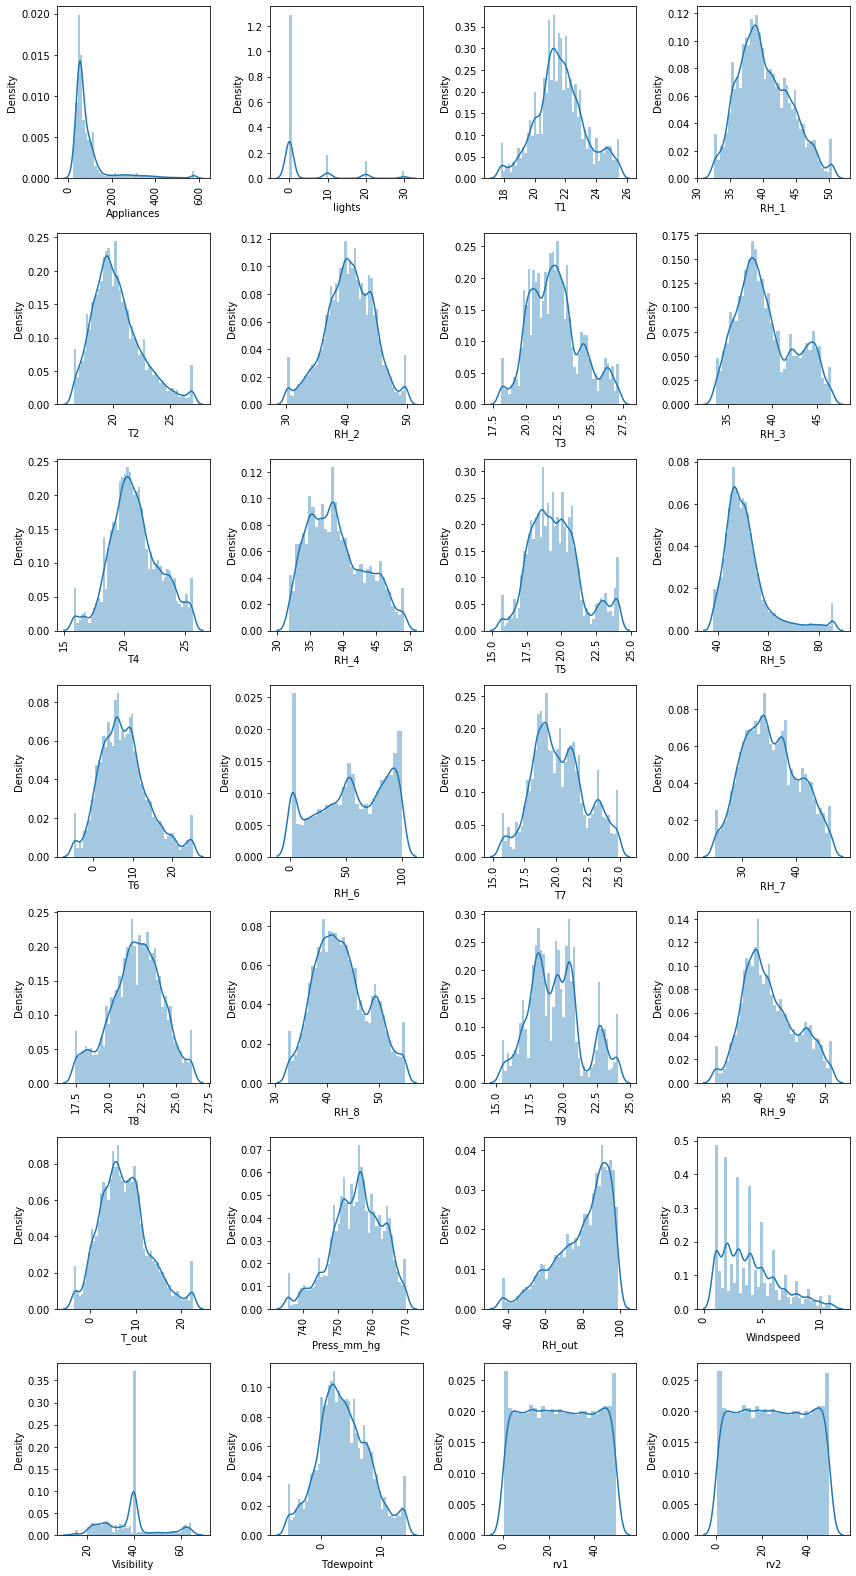

In [15]:
#Checking distribution of all the features
plt.figure(figsize = (12,22))
for i, col in enumerate(data_energy.columns):
    plt.subplot(7, 4, i+1)
    plt.subplots_adjust(hspace = 1, wspace = .5)
    sns.distplot(data_energy[col])
    plt.xticks(rotation = 90)
    plt.tight_layout()

#### Correlation Matrix

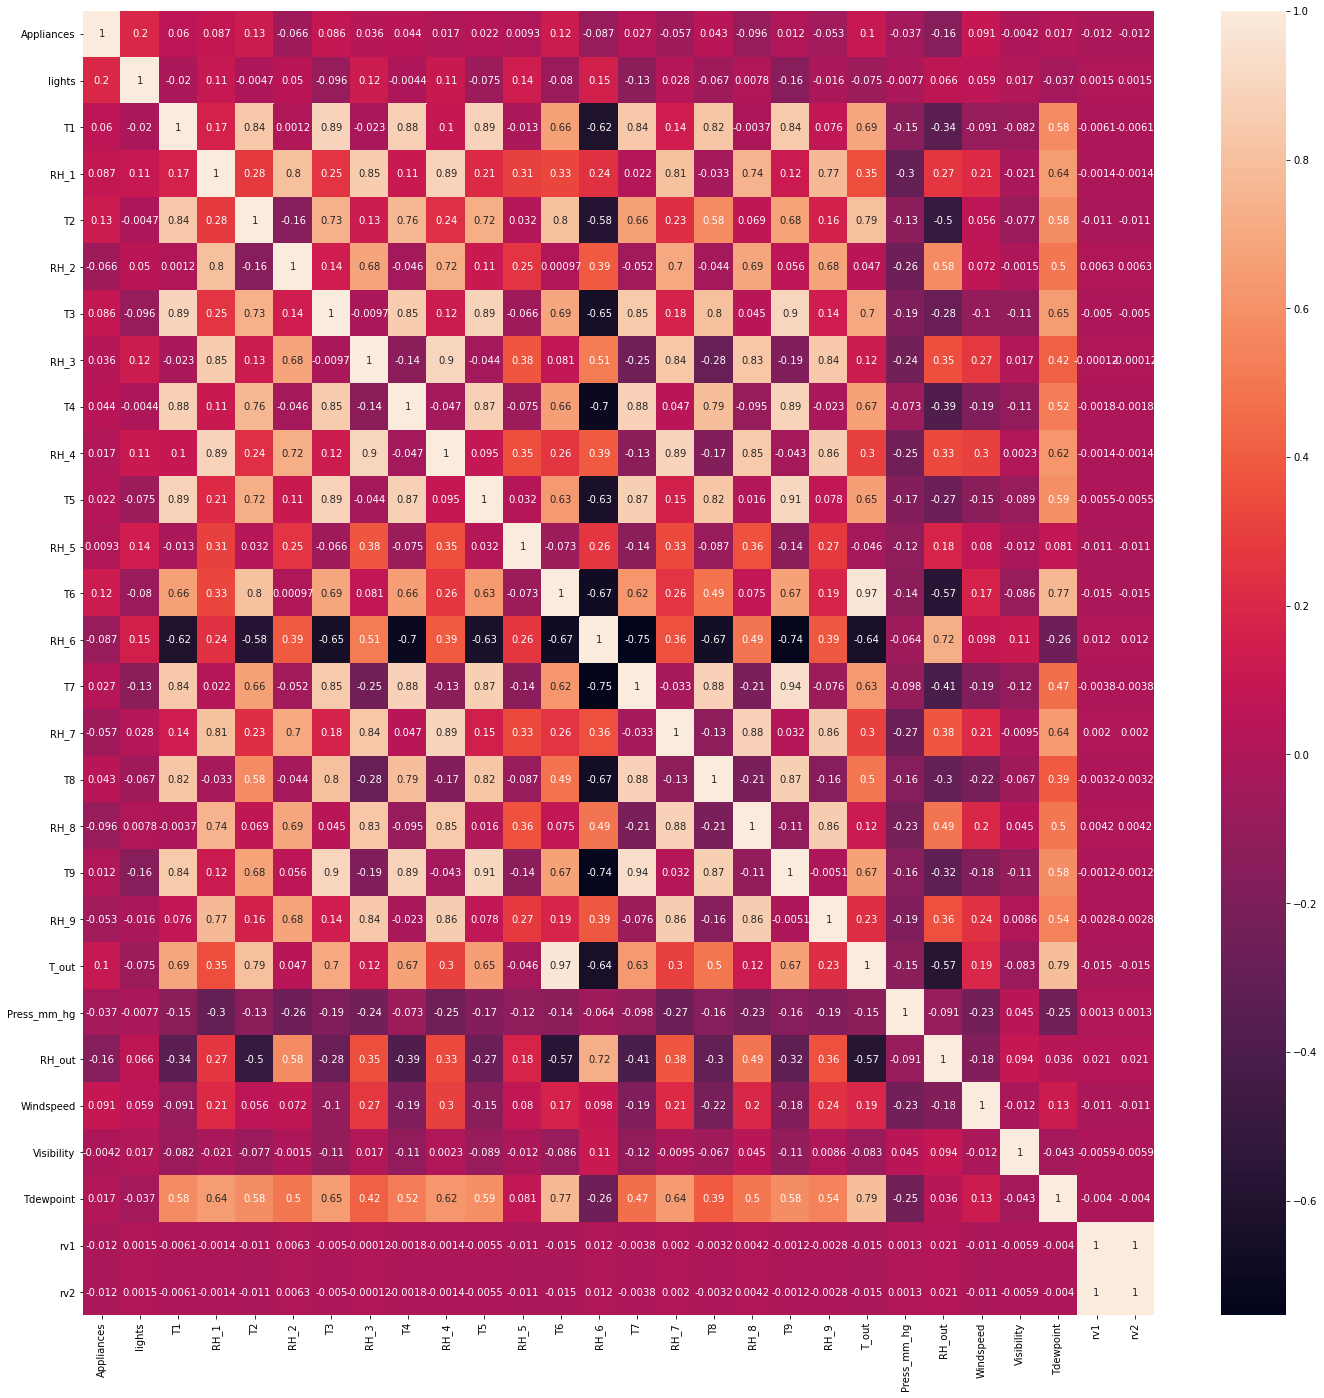

In [16]:
plt.figure(figsize = (24,24))
sns.heatmap(data_energy.corr(), annot = True)
plt.show()

#### Feature Selection

In [17]:
#Using F-Regression
#Getting features and target
feat_cols = data_energy.columns.difference(['Appliances'])
target = data_energy.Appliances

#Performing f-test for each x variable with y
f_values, p_values = f_regression(data_energy[feat_cols], target)

#Storing data as a DataFrame
fr_df = pd.DataFrame({'Features':feat_cols, 'F_values':f_values, 'p_values':p_values.round(3)})

#Getting significant variables at 90% : p = 0.1
f_cols = fr_df.loc[fr_df.p_values<=0.1, 'Features'].reset_index(drop = True)
f_cols

0     Press_mm_hg
1            RH_1
2            RH_2
3            RH_3
4            RH_4
5            RH_6
6            RH_7
7            RH_8
8            RH_9
9          RH_out
10             T1
11             T2
12             T3
13             T4
14             T5
15             T6
16             T7
17             T8
18             T9
19          T_out
20      Tdewpoint
21      Windspeed
22         lights
Name: Features, dtype: object

In [18]:
#Using Recursive Feature Elimination (RFE)
#Using RandomForestRegressor as an estimator
rf_est = RandomForestRegressor(random_state = 55, n_jobs = -1)

#Using RFE to get importance of each variable
rfe = RFE(estimator =rf_est, n_features_to_select = 20)
rfe.fit(data_energy[f_cols], target)

print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True False False  True  True  True]
[1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 4 2 1 1 1]


In [19]:
#Getting important features
rfe_cols = f_cols[rfe.support_].reset_index(drop = True)

#### Train and Test Data

In [20]:
#For Statistical modelling
train, test = train_test_split(data_energy, test_size = 0.3, random_state = 55)

In [21]:
#Getting final model equation
'Appliances ~ '+' + '.join(rfe_cols)

'Appliances ~ Press_mm_hg + RH_1 + RH_2 + RH_3 + RH_4 + RH_6 + RH_7 + RH_8 + RH_9 + RH_out + T2 + T3 + T4 + T5 + T6 + T7 + T8 + Tdewpoint + Windspeed + lights'

In [22]:
mo_fm = '''Appliances ~ Press_mm_hg + RH_1 + RH_2 + RH_3 + RH_6 + RH_8 + RH_9 + RH_out +
                        T2 + T3 + T4 + T5 + T6 + T7 + T8 + Tdewpoint + Windspeed + lights'''

### Linear Regression Model

In [23]:
#building model
lm = smf.ols(formula = mo_fm, data = train).fit()

In [24]:
#Model Summary
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:             Appliances   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     161.2
Date:                Wed, 15 Sep 2021   Prob (F-statistic):               0.00
Time:                        17:59:28   Log-Likelihood:                -81464.
No. Observations:               13814   AIC:                         1.630e+05
Df Residuals:                   13795   BIC:                         1.631e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -254.9487    100.525     -2.536      

Dropped features from model equation with p-value > 0.05 means insignificant features - RH_4, RH_7

In [25]:
#Predicting total spent on train and test dataset
train.loc[:,'pred_app'] = lm.predict(train)
test.loc[:, 'pred_app'] = lm.predict(test)

#Getting Mean Absolute Percentage Error - MAPE
MAPE_train = np.mean(np.abs(train['Appliances'] - train['pred_app'])/train['Appliances'])
MAPE_test = np.mean(np.abs(test['Appliances'] - test['pred_app'])/test['Appliances'])

print('Training MAPE: ',MAPE_train,' | ','Testing MAPE:' ,MAPE_test)

Training MAPE:  0.6038181286771297  |  Testing MAPE: 0.6148021528172433


In [26]:
#Getting Mean Squared Error Metric - MSE
MSE_train = metrics.mean_squared_error(train.Appliances, train.pred_app)
MSE_test = metrics.mean_squared_error(test.Appliances, test.pred_app)

#Getting Root Mean Squared Error - RMSE
RMSE_train = np.sqrt(MSE_train)
lr_RMSE_test = np.sqrt(MSE_test)

print('Training MSE: ',MSE_train,' | ','Testing MSE:' ,MSE_test)
print('Training RMSE: ',RMSE_train,' | ','Testing RMSE:' ,lr_RMSE_test)

Training MSE:  7758.157204502048  |  Testing MSE: 7980.309693425793
Training RMSE:  88.08040193199648  |  Testing RMSE: 89.332579126687


In [27]:
#Getting Mean Absolute Error Metric - MAE
MAE_train = metrics.mean_absolute_error(train.Appliances, train.pred_app)
lr_MAE_test = metrics.mean_absolute_error(test.Appliances, test.pred_app)

print('Training MAE: ',MAE_train,' | ','Testing MAE:' ,lr_MAE_test)

Training MAE:  51.80395901579748  |  Testing MAE: 52.50074603804165


In [28]:
#Correlation between actual and predicted values
Corr_train = stats.stats.pearsonr(train.Appliances, train.pred_app)
Corr_test = stats.stats.pearsonr(test.Appliances, test.pred_app)

print('Correlation - Train Data: ', Corr_train, '|', 'Test Data: ', Corr_test)

Correlation - Train Data:  (0.4168376138055043, 0.0) | Test Data:  (0.3834307223540353, 1.1131031126756925e-206)


In [29]:
#Decile Analysis
#Creating Deciles
train.loc[:, 'Deciles'] = pd.qcut(train.pred_app, 10, labels = False)
test.loc[:, 'Deciles'] = pd.qcut(test.pred_app, 10, labels = False)

#Summarizing the data by deciles on train and test dataset
decile_train = train.groupby(['Deciles'])[['Appliances','pred_app']].mean().reset_index().sort_values(by = 'Deciles', ascending = False)
decile_test = test.groupby(['Deciles'])[['Appliances','pred_app']].mean().reset_index().sort_values(by = 'Deciles', ascending = False)

In [30]:
#Deciles of train dataset
decile_train.round(2)

,Deciles,Appliances,pred_app
9,9,193.82,181.05
8,8,140.74,137.59
7,7,120.73,118.78
6,6,95.44,104.98
5,5,78.55,94.42
4,4,78.88,85.30
3,3,70.70,76.88
2,2,64.99,68.05
1,1,63.10,58.56
0,0,59.49,40.83


In [31]:
#Deciles of test dataset
decile_test.round(2)

,Deciles,Appliances,pred_app
9,9,193.35,182.48
8,8,132.77,138.57
7,7,112.23,120.22
6,6,97.18,105.37
5,5,81.68,94.73
4,4,77.36,85.96
3,3,72.88,77.47
2,2,70.83,68.78
1,1,70.04,59.09
0,0,59.92,40.29


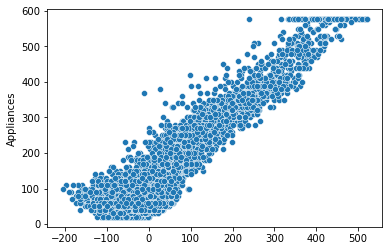

In [32]:
#Residual plot with target values
sns.scatterplot(x = lm.resid, y = train.Appliances)
plt.show()

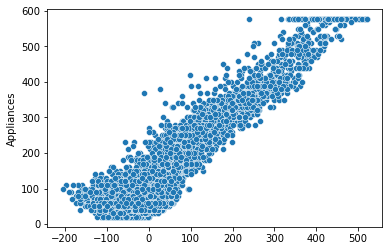

In [33]:
#Calculating residual
residual = train.Appliances - train.pred_app

#Calculated Residual plot with target values
sns.scatterplot(x = residual, y = train.Appliances)
plt.show()

<AxesSubplot:ylabel='Density'>

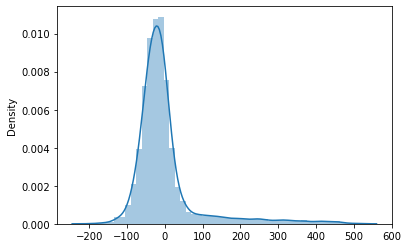

In [34]:
#Checking distribution of calculated residuals
sns.distplot(residual)

In [35]:
#Getting final features
X_cols = lm.pvalues.index.difference(['Intercept'])
X = data_energy[X_cols]
Y = data_energy.Appliances

<BarContainer object of 18 artists>

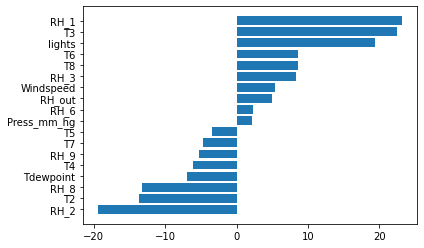

In [36]:
#Getting importance of factors
lr_fi = pd.DataFrame({'Features' : lm.tvalues[1:].index,
                      'T_value' : lm.tvalues[1:]
                     }).sort_values(by = 'T_value').reset_index(drop = True)
plt.barh(width = lr_fi.T_value, y = lr_fi.Features)

#### Getting Train and Test dataset for Machine Learning modelling

In [37]:
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.3, random_state = 55)

### Decision Tree Model

In [38]:
#Getting parameters for best fit using GridSeachCV
pg = {  'max_depth' : range(32,38,1),
        'min_samples_split' : [2,3,4],
        'min_samples_leaf' : range(7,10,1)
     }

gscv_dt = GridSearchCV(estimator = DecisionTreeRegressor(random_state = 55), 
                     param_grid = pg,
                     cv = 5,
                     n_jobs = -1).fit(train_x, train_y)

In [39]:
#Best fit Parameters
gscv_dt.best_params_

{'max_depth': 35, 'min_samples_leaf': 8, 'min_samples_split': 2}

In [40]:
#Best Score
gscv_dt.best_score_

0.2810256376326004

In [41]:
#Using best fit parameters to fit the model
dt = gscv_dt.best_estimator_

#R2 score 
dt_r2 = metrics.r2_score(test_y, dt.predict(test_x))
print('R2 Score:', dt_r2)

#Predicting total spent on train and test dataset
train.loc[:, 'dt_pred_app'] = dt.predict(train_x)
test.loc[:, 'dt_pred_app'] = dt.predict(test_x)

#Getting Mean Absolute Percentage Error - MAPE
MAPE_train = np.mean(np.abs(train['Appliances'] - train['dt_pred_app'])/train['Appliances'])
MAPE_test = np.mean(np.abs(test['Appliances'] - test['dt_pred_app'])/test['Appliances'])

print('Training MAPE: ',MAPE_train,' | ','Testing MAPE:' ,MAPE_test)

R2 Score: 0.24398919087335236
Training MAPE:  0.2740353730781341  |  Testing MAPE: 0.433835573246022


In [42]:
#Getting Mean Squared Error Metric - MSE
MSE_train = metrics.mean_squared_error(train.Appliances, train.dt_pred_app)
MSE_test = metrics.mean_squared_error(test.Appliances, test.dt_pred_app)

#Getting Root Mean Squared Error - RMSE
RMSE_train = np.sqrt(MSE_train)
dt_RMSE_test = np.sqrt(MSE_test)

print('Training MSE: ',MSE_train,' | ','Testing MSE:' ,MSE_test)
print('Training RMSE: ',RMSE_train,' | ','Testing RMSE:' ,dt_RMSE_test)

Training MSE:  3338.7098241800522  |  Testing MSE: 7060.730800128101
Training RMSE:  57.78156993523153  |  Testing RMSE: 84.02815480616066


In [43]:
#Getting Mean Absolute Error Metric - MAE
MAE_train = metrics.mean_absolute_error(train.Appliances, train.dt_pred_app)
dt_MAE_test = metrics.mean_absolute_error(test.Appliances, test.dt_pred_app)

print('Training MAE: ',MAE_train,' | ','Testing MAE:', dt_MAE_test)

Training MAE:  28.06312880369633  |  Testing MAE: 42.82337090352458


In [44]:
#Correlation between actual and predicted values
Corr_train = stats.stats.pearsonr(train.Appliances, train.dt_pred_app)
Corr_test = stats.stats.pearsonr(test.Appliances, test.dt_pred_app)

print('Correlation - Train Data: ', Corr_train, '|', 'Test Data: ', Corr_test)

Correlation - Train Data:  (0.8027616448110331, 0.0) | Test Data:  (0.5481571151653173, 0.0)


In [45]:
#Decile Analysis
#Creating Deciles
train.loc[:, 'dt_Deciles'] = pd.qcut(train.dt_pred_app, 10, labels = False)
test.loc[:, 'dt_Deciles'] = pd.qcut(test.dt_pred_app, 10, labels = False)

#Summarizing the data by deciles on train and test dataset
decile_train = train.groupby(['dt_Deciles'])[['Appliances','dt_pred_app']].mean().reset_index().sort_values(by = 'dt_Deciles', ascending = False)
decile_test = test.groupby(['dt_Deciles'])[['Appliances','dt_pred_app']].mean().reset_index().sort_values(by = 'dt_Deciles', ascending = False)

In [46]:
decile_train

,dt_Deciles,Appliances,dt_pred_app
9,9,293.249964,293.249964
8,8,160.618051,160.618051
7,7,108.183792,108.183792
6,6,86.990573,86.990573
5,5,69.905797,69.905797
4,4,59.876453,59.876453
3,3,54.915503,54.915503
2,2,50.478571,50.478571
1,1,45.772059,45.772059
0,0,37.355021,37.355021


In [47]:
decile_test

,dt_Deciles,Appliances,dt_pred_app
9,9,218.653356,288.077098
8,8,157.097171,165.423555
7,7,119.767347,112.317526
6,6,104.188926,88.834983
5,5,85.845531,71.412115
4,4,68.970840,60.499466
3,3,62.022957,55.279823
2,2,57.024092,51.107057
1,1,50.351759,46.283451
0,0,46.416972,37.531599


### Random Forest Model

In [48]:
#Getting parameters for best fit using GridSeachCV
pg = {  'max_depth' : range(22,27,1),
        'min_samples_split' : [2,3,4],
        'min_samples_leaf' : range(5,10,1)
              }

gscv_rf = GridSearchCV(estimator = RandomForestRegressor(random_state = 55), 
                     param_grid = pg,
                     scoring = 'neg_mean_squared_error',
                     cv = 5,
                     n_jobs = -1).fit(train_x, train_y)

In [49]:
#Best fit Parameters
gscv_rf.best_params_

{'max_depth': 24, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [50]:
#Best Score
-1*gscv_rf.best_score_

5174.3607796244505

In [51]:
#Using best fit parameters to fit the model
rf = gscv_rf.best_estimator_

#R2 score 
rf_r2 = metrics.r2_score(test_y, rf.predict(test_x))
print('R2 Score:', rf_r2)

#Predicting total spent on train and test dataset
train.loc[:, 'rf_pred_app'] = rf.predict(train_x)
test.loc[:, 'rf_pred_app'] = rf.predict(test_x)

#Getting Mean Absolute Percentage Error - MAPE
MAPE_train = np.mean(np.abs(train['Appliances'] - train['rf_pred_app'])/train['Appliances'])
MAPE_test = np.mean(np.abs(test['Appliances'] - test['rf_pred_app'])/test['Appliances'])
                    
print('Training MAPE: ',MAPE_train,' | ','Testing MAPE:' ,MAPE_test)

R2 Score: 0.4556966987399902
Training MAPE:  0.24263509357929294  |  Testing MAPE: 0.3606958617280251


In [52]:
#Getting Mean Squared Error Metric - MSE
MSE_train = metrics.mean_squared_error(train.Appliances, train.rf_pred_app)
MSE_test = metrics.mean_squared_error(test.Appliances, test.rf_pred_app)

#Getting Root Mean Squared Error - RMSE
RMSE_train = np.sqrt(MSE_train)
rf_RMSE_test = np.sqrt(MSE_test)

print('Training MSE: ',MSE_train,' | ','Testing MSE:' ,MSE_test)
print('Training RMSE: ',RMSE_train,' | ','Testing RMSE:' ,rf_RMSE_test)

Training MSE:  2435.5187456138833  |  Testing MSE: 5083.4975339276425
Training RMSE:  49.350975123232196  |  Testing RMSE: 71.29865029527306


In [53]:
#Getting Mean Absolute Error Metric - MAE
MAE_train = metrics.mean_absolute_error(train.Appliances, train.rf_pred_app)
rf_MAE_test = metrics.mean_absolute_error(test.Appliances, test.rf_pred_app)

print('Training MAE: ',MAE_train,' | ','Testing MAE:' ,rf_MAE_test)

Training MAE:  24.275680750726885  |  Testing MAE: 35.82391810605382


In [54]:
#Correlation between actual and predicted values
Corr_train = stats.stats.pearsonr(train.Appliances, train.rf_pred_app)
Corr_test = stats.stats.pearsonr(test.Appliances, test.rf_pred_app)

print('Correlation - Train Data: ', Corr_train, '|', 'Test Data: ', Corr_test)

Correlation - Train Data:  (0.8811216092957262, 0.0) | Test Data:  (0.6786213617485248, 0.0)


In [55]:
#Decile Analysis
#Creating Deciles
train.loc[:, 'rf_Deciles'] = pd.qcut(train.rf_pred_app, 10, labels = False)
test.loc[:, 'rf_Deciles'] = pd.qcut(test.rf_pred_app, 10, labels = False)

#Summarizing the data by deciles on train and test dataset
decile_train = train.groupby(['rf_Deciles'])[['Appliances','rf_pred_app']].mean().reset_index().sort_values(by = 'rf_Deciles', ascending = False)
decile_test = test.groupby(['rf_Deciles'])[['Appliances','rf_pred_app']].mean().reset_index().sort_values(by = 'rf_Deciles', ascending = False)

In [56]:
decile_train

,rf_Deciles,Appliances,rf_pred_app
9,9,326.006657,262.736732
8,8,143.048516,152.208095
7,7,101.976828,116.324873
6,6,81.541245,93.944318
5,5,67.002172,76.957480
4,4,58.508327,64.856447
3,3,54.305355,57.886103
2,2,51.122375,53.361927
1,1,46.140478,48.500968
0,0,36.729378,40.714088


In [57]:
decile_test

,rf_Deciles,Appliances,rf_pred_app
9,9,253.648649,236.036499
8,8,150.522635,150.991616
7,7,125.123311,119.392591
6,6,97.505405,98.680196
5,5,80.000000,82.373975
4,4,62.415541,69.745335
3,3,56.773649,60.632775
2,2,52.381757,54.810462
1,1,48.817568,49.939854
0,0,41.096121,42.187130


### Artificial Neural Network (ANN) Model

In [58]:
#Input data shape
train_x.shape

(13814, 18)

In [59]:
sc_train_x = pd.DataFrame(StandardScaler().fit_transform(train_x), columns = train_x.columns, index = train_x.index)

In [60]:
sc_test_x = pd.DataFrame(StandardScaler().fit_transform(test_x), columns = test_x.columns, index = test_x.index)

In [61]:
#Initializing and fitting MLP Regression model
mlp = MLPRegressor(activation='relu', solver='adam',learning_rate='adaptive',
                   max_iter=1000,learning_rate_init=0.01,
                   alpha=0.01).fit(sc_train_x, train_y)

In [62]:
#R2 score 
ann_r2 = metrics.r2_score(train_y, mlp.predict(sc_train_x))
print('R2 Score:', ann_r2)

R2 Score: 0.4487584352327445


In [63]:
#Predicting total spent on train and test dataset
train.loc[:, 'ann_pred_app'] = mlp.predict(sc_train_x)
test.loc[:, 'ann_pred_app'] = mlp.predict(sc_test_x)

#Getting Mean Absolute Percentage Error - MAPE
MAPE_train = np.mean(np.abs(train['Appliances'] - train['ann_pred_app'])/train['Appliances'])
MAPE_test = np.mean(np.abs(test['Appliances'] - test['ann_pred_app'])/test['Appliances'])
                    
print('Training MAPE:',MAPE_train,' | ','Testing MAPE:' ,MAPE_test)

Training MAPE: 0.5083627803524247  |  Testing MAPE: 0.5423294079012156


In [64]:
#Getting Mean Squared Error Metric - MSE
MSE_train = metrics.mean_squared_error(train.Appliances, train.ann_pred_app)
MSE_test = metrics.mean_squared_error(test.Appliances, test.ann_pred_app)

#Getting Root Mean Squared Error - RMSE
RMSE_train = np.sqrt(MSE_train)
ann_RMSE_test = np.sqrt(MSE_test)

print('Training MSE: ',MSE_train,' | ','Testing MSE:' ,MSE_test)
print('Training RMSE: ',RMSE_train,' | ','Testing RMSE:' ,ann_RMSE_test)

Training MSE:  5175.9604615298385  |  Testing MSE: 6194.508246595484
Training RMSE:  71.94414820907839  |  Testing RMSE: 78.70519834544275


In [65]:
#Getting Mean Absolute Error Metric - MAE
MAE_train = metrics.mean_absolute_error(train.Appliances, train.ann_pred_app)
ann_MAE_test = metrics.mean_absolute_error(test.Appliances, test.ann_pred_app)

print('Training MAE: ',MAE_train,' | ','Testing MAE:' ,ann_MAE_test)

Training MAE:  42.87685669344354  |  Testing MAE: 46.536086274261066


In [66]:
#Correlation between actual and predicted values
Corr_train = stats.stats.pearsonr(train.Appliances, train.ann_pred_app)
Corr_test = stats.stats.pearsonr(test.Appliances, test.ann_pred_app)

print('Correlation - Train Data: ', Corr_train, '|', 'Test Data: ', Corr_test)

Correlation - Train Data:  (0.6730911273148936, 0.0) | Test Data:  (0.5825894701494753, 0.0)


In [67]:
#Decile Analysis
#Creating Deciles
train.loc[:, 'ann_Deciles'] = pd.qcut(train.ann_pred_app, 10, labels = False)
test.loc[:, 'ann_Deciles'] = pd.qcut(test.ann_pred_app, 10, labels = False)

#Summarizing the data by deciles on train and test dataset
decile_train = train.groupby(['ann_Deciles'])[['Appliances','ann_pred_app']].mean().reset_index().sort_values(by = 'ann_Deciles', ascending = False)
decile_test = test.groupby(['ann_Deciles'])[['Appliances','ann_pred_app']].mean().reset_index().sort_values(by = 'ann_Deciles', ascending = False)

In [68]:
decile_train

,ann_Deciles,Appliances,ann_pred_app
9,9,268.875543,238.916290
8,8,146.593628,155.135343
7,7,111.904127,124.341379
6,6,91.164834,104.876221
5,5,72.172339,90.289105
4,4,62.309920,78.246727
3,3,56.439942,68.755521
2,2,55.655322,59.988385
1,1,52.657495,49.543695
0,0,48.632417,32.436425


In [69]:
decile_test

,ann_Deciles,Appliances,ann_pred_app
9,9,238.632095,234.653831
8,8,145.629730,157.828025
7,7,121.013176,126.680015
6,6,103.259459,107.173614
5,5,73.203716,92.433218
4,4,68.496622,79.857642
3,3,57.753378,69.570669
2,2,56.210473,60.376051
1,1,53.429054,49.590447
0,0,50.640809,31.366792


#### Evaluating the different metrics for each model

In [70]:
#Getting accuracy and log loss for each model
model_data = pd.DataFrame({'Regressor' : ['LinearRegressor', 'DecisionTreeRegressor', 'RandomForestRegressor', 'ArtificialNeuralNetwork'],
                        'R2 Score' : [lm.rsquared, dt_r2, rf_r2, ann_r2],
                        'RMSE' : [lr_RMSE_test, dt_RMSE_test, rf_RMSE_test, ann_RMSE_test],
                        'MAE' : [lr_MAE_test, dt_MAE_test, rf_MAE_test, ann_MAE_test]})

In [71]:
model_data

,Regressor,R2 Score,RMSE,MAE
0,LinearRegressor,0.173754,89.332579,52.500746
1,DecisionTreeRegressor,0.243989,84.028155,42.823371
2,RandomForestRegressor,0.455697,71.298650,35.823918
3,ArtificialNeuralNetwork,0.448758,78.705198,46.536086


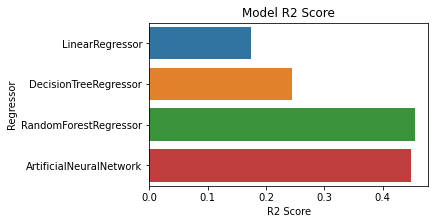

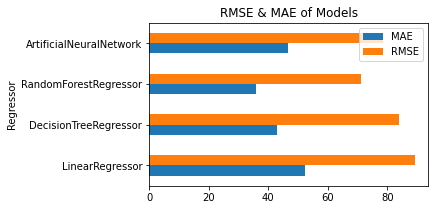

In [72]:
#Visualizing the accuracy and log loss of each model
plt.figure(figsize = (5,3))
sns.barplot(data = model_data, x = model_data['R2 Score'], y = model_data.Regressor)
plt.title('Model R2 Score')
plt.show()

model_data.plot(x = 'Regressor', y = ['MAE', 'RMSE'], kind = 'barh', figsize = (5,3))
plt.title('RMSE & MAE of Models')
plt.show()

Random Forest Model has the highest R2 Score and the lowest MAE and RMSE Score. So, we will choose Random Forest Model for Predicting Appliances Energy.